In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf

In [10]:
URL="https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=748&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=POILBREUSDM&scale=left&cosd=1980-01-01&coed=2017-06-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-03-22&revision_date=2019-03-22&nd=1980-01-01"
oilprice= pd.read_csv(URL )
oilprice["DATE"]= pd.to_datetime(oilprice["DATE"])
oilprice.set_index("DATE", inplace=True)

#oilprice=oilprice[] #keep prices from 1990
oilprice.rename(columns={"POILBREUSDM":"Price"}, inplace=True)
oilprice=oilprice["1990-01-01":]

In [11]:
#convert to timeseries
oil_ts=oilprice["Price"]
oil_ts['1994-01-01']

14.22

In [12]:
#stationarity checks:Dickey fuller test
def stationarity_test(data):
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
   

In [13]:
 stationarity_test(oil_ts)
    #not stationary data

Test Statistic                  -1.982404
p-value                          0.294341
#Lags Used                       1.000000
Number of Observations Used    328.000000
Critical Value (1%)             -3.450445
Critical Value (5%)             -2.870392
Critical Value (10%)            -2.571486
dtype: float64


Test Statistic                -1.372266e+01
p-value                        1.179864e-25
#Lags Used                     0.000000e+00
Number of Observations Used    3.280000e+02
Critical Value (1%)           -3.450445e+00
Critical Value (5%)           -2.870392e+00
Critical Value (10%)          -2.571486e+00
dtype: float64


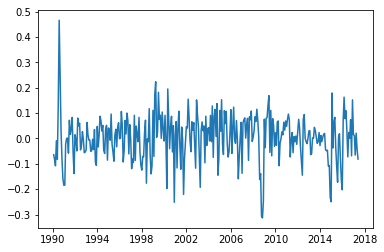

In [14]:
#convert to stationary using differencing
oil_ts_log= np.log(oil_ts) #log of oil price
oil_ts_logdiff= (oil_ts_log - oil_ts_log.shift()) #first log difference
oil_ts_logdiff.dropna(inplace=True)  #lose one data point due to differencing

oil_ts_logdiff.count

stationarity_test(oil_ts_logdiff)
#very small p value, hence the series is stationary
plt.plot(oil_ts_logdiff)

Text(0.5,1,'Partial Autocorrelation Function')

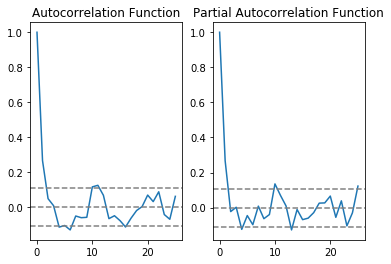

In [23]:
#Forecasting using Arima
lag_AR=acf(oil_ts_logdiff, nlags=25)
lag_MA=pacf(oil_ts_logdiff, nlags=25, method='ols')
#ACF plot 
plt.subplot(121)
plt.plot(lag_AR)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(oil_ts_logdiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(oil_ts_logdiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
            
#PACF plot            

plt.subplot(122)
plt.plot(lag_MA)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(oil_ts_logdiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(oil_ts_logdiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


In [24]:
# The ACF plot crosses the upper interval around lag 1 or the first time and similarily for PACF so p and q=1

C:\Users\bhavna\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\bhavna\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: nan')

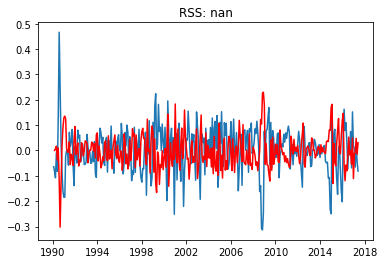

In [25]:
model= ARIMA(oil_ts_logdiff, order=(1,1,1))
results=model.fit(disp=-1)
plt.plot(oil_ts_logdiff)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-oil_ts_logdiff)**2))


In [26]:
#converting to original scale

pred_diff= pd.Series(results.fittedvalues, copy=True)
pred_diff_cum=pred_diff.cumsum()
pred_log=pd.Series(oil_ts_log.iloc[0], index=oil_ts_log.index)
pred_log=pred_log.add(pred_diff_cum, fill_value=0)


<function matplotlib.pyplot.legend(*args, **kwargs)>

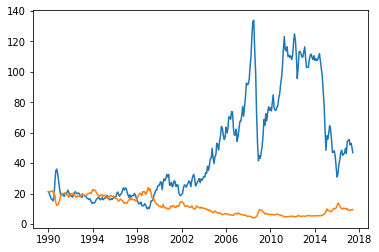

In [22]:
final_pred=np.exp(pred_log)
plt.plot(oil_ts, label='Original Time Series')
plt.plot(final_pred, label='Predicted')
plt.legend
